# Прогнозирование заказов для компании "Чётенькое такси"

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нам необходимо построить модель для такого предсказания. Заказчик требует, чтобы значение метрики RMSE на тестовой выборке было не больше 48.
    
Предоставлены данные за март-август 2018 года, в виде количества заказов на каждые 10 минут каждого дня.

Нам нужно:

- Загрузить данные и выполнить их ресемплирование по одному часу.
- Проанализировать данные.
- Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
- Проверить данные на тестовой выборке и сделать выводы.
    
 
    
____



В данном исследовании представлен процесс создания и проверки моделей машинного обучения в целях прогнозирования заказов. Работа произведена в соответствии с инструкциями заказчика. Каждый значительный шаг сопровождается промежуточным, либо общим выводом.
 
    
    
____
    

    
    
    
Часть 1. Изучение общей информации о предоставленном датасете
    
1. Импорт необходимых библиотек для работы с данными, загрузка датасета
2. Изучение данных, получение общей информации
3. Вывод

Часть 2. Подготовка данных

1. Распределение заказов
2. Создание дамми модели
3. Вывод
    
Часть 3. Обучение моделей
    
1. Подготовка данных
2. Линейная регрессия
3. Случайный лес
4. LGBM
5. CatBoost
6. Вывод
    
Часть 4. Тестирование моделей
    
1. Тестирование моделей   
2. Вывод

 ## Часть 1. Изучение общей информации о предоставленном датасете

<a id='Импорт необходимых библиотек для работы с данными, загрузка датасета'>

### <p style="text-align:center"> Импорт необходимых библиотек для работы с данными, загрузка датасета</p>

Импортируем необходимые библиотеки, убираем ограничения на количество столбцов, отключаем предупреждения.

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import warnings
warnings.simplefilter('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Загружаем датасет, проверяем вывод.

In [5]:
raw_data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
raw_data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<a id='Изучение данных, получение общей информации'></a>

### <p style="text-align:center"> Изучение данных, получение общей информации</p>

Ознакомимся с информацией, посмотрим соответствуют ли типы ячеек назначению. В качестве дополнительной проверки возьмем случайные 20 строк из нашего датасета, посмотрим на странные, выбивающиеся, отсутствующие значения.

In [6]:
raw_data.sample(n=20, random_state=1)

,num_orders
datetime,
2018-06-14 20:50:00,29
2018-06-21 19:40:00,4
2018-07-31 05:00:00,7
2018-03-27 06:20:00,0
2018-08-06 01:10:00,26
2018-04-21 20:30:00,8
2018-03-10 18:40:00,20
2018-04-16 19:20:00,8
2018-05-31 01:40:00,4


Иногда в таблицах в конце есть строка "Итого"(или т.п.), нам она не нужна, убедимся в ее отсутствии.

In [7]:
raw_data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
raw_data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<a id='Вывод_1'></a>

### <p style="text-align:center"> Вывод</p>

##### В ходе первичного анализа данных были  сделаны следующие выводы:

___


1. Предоставлены данные за март-август 2018 года, в виде количества заказов на каждые 10 минут каждого дня.


2. В датасете 26496 строк, странностей не выявлено.

___

Таким образом было выполнено первичное ознакомление с предоставленной информацией, дефекты датасета не выявлены. Данные не нуждаются в предобработке. Можно переходить к подготовке данных.

 ## Часть 2. Подготовка данных

<a id='Распределение заказов'></a>

### <p style="text-align:center">Распределение заказов</p>

In [10]:
df = raw_data.copy()

In [11]:
raw_data.sort_index(inplace=True)

Посмотрим на распределение заказов.

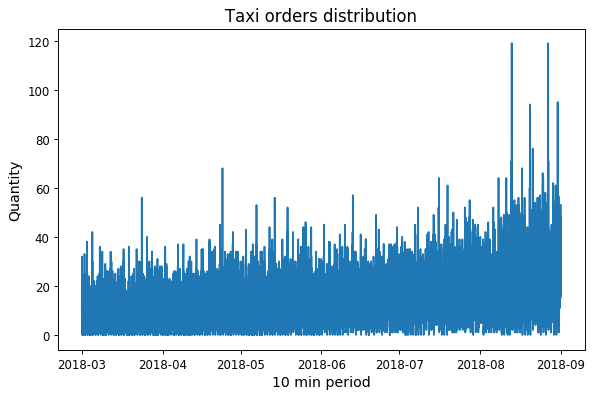

In [12]:
plt.figure(figsize=(8,5), dpi = 85);
plt.plot(raw_data);
plt.title('Taxi orders distribution', fontsize=14);
plt.ylabel('Quantity', fontsize=12);
plt.xlabel('10 min period', fontsize=12);

Ничего не понятно, разделим данные на дни и месяцы.

In [13]:
month_orders = raw_data['num_orders'].resample('1M').sum()
day_orders = raw_data['num_orders'].resample('1D').sum()

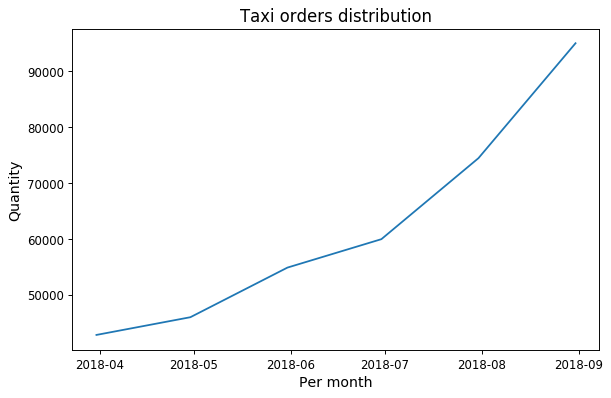

In [14]:
plt.figure(figsize=(8,5), dpi = 85);
plt.plot(month_orders);
plt.title('Taxi orders distribution', fontsize=14);
plt.ylabel('Quantity', fontsize=12);
plt.xlabel('Per month', fontsize=12);

Заметили восходящий к августу тренд, связан с увеличивающимся количеством перелетов летом.

Посмотрим поближе. Проиллюстрируем количество заказов по дням.

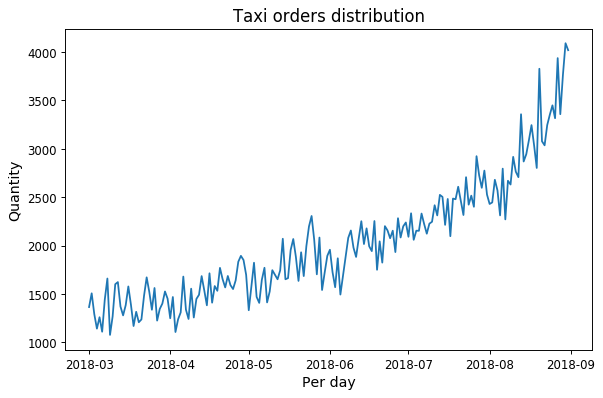

In [15]:
plt.figure(figsize=(8,5), dpi = 85);
plt.plot(day_orders);
plt.title('Taxi orders distribution', fontsize=14);
plt.ylabel('Quantity', fontsize=12);
plt.xlabel('Per day', fontsize=12);

Посмотрим на сезонности, сразу добавим скользящие средние.

In [16]:
raw_data = raw_data.resample('1H').sum()

In [17]:
raw_data['rolling_mean'] = raw_data['num_orders'].shift().rolling(10).mean()
raw_data['std'] = raw_data['num_orders'].rolling(10).std()
raw_data = raw_data.dropna()

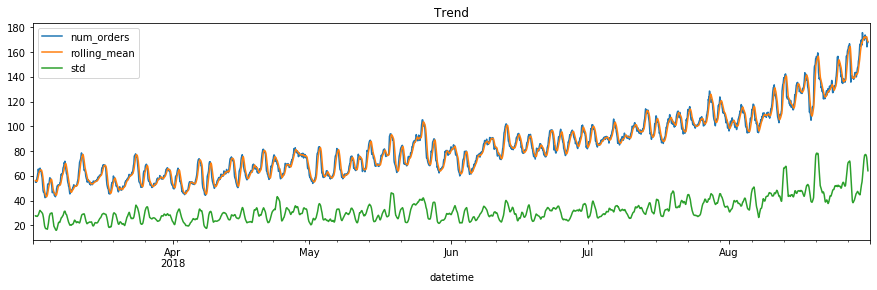

In [18]:
decomposed = seasonal_decompose(raw_data)
decomposed.trend.plot(title='Trend', figsize=(15,4));

Существует какая-то закономерность в периодичности пиков, посмотрим на это поближе.

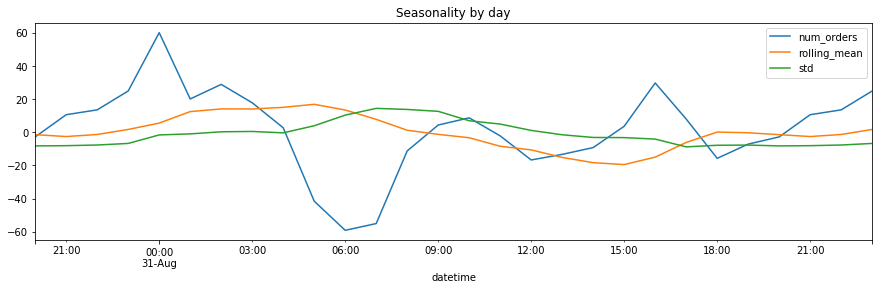

In [19]:
decomposed.seasonal.tail(28).plot(title='Seasonality by day', figsize=(15,4));

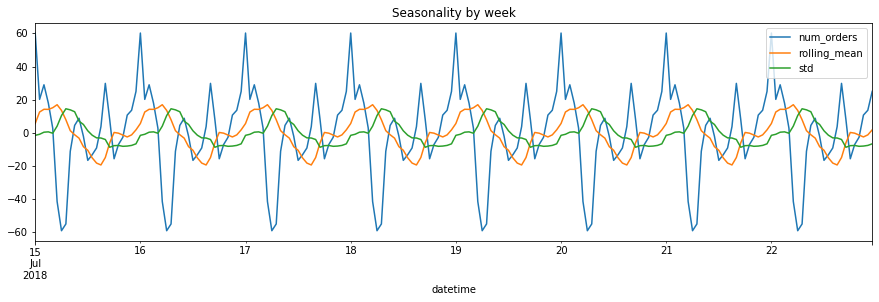

In [20]:
decomposed.seasonal['2018-07-15':'2018-07-22'].plot(title='Seasonality by week', figsize=(15,4));

Заметим, что наименьшее количество заказов наблюдается в 6 утра.

<a id='Создание дамми модели'></a>

### <p style="text-align:center">Создание дамми модели</p>

In [21]:
raw_train, raw_test = train_test_split(raw_data['num_orders'], shuffle=False, test_size=0.1)

In [22]:
pred_median = np.ones(raw_test.shape) * raw_train.median()
rmse = np.sqrt(mean_squared_error(raw_test, pred_median))
rmse

87.24205906985632

In [23]:
pred_previous = raw_test.shift()
pred_previous.iloc[0] = raw_train.iloc[-1]
rmse = np.sqrt(mean_squared_error(raw_test, pred_previous))
rmse

58.91761802963282

В качестве основной дамми модели примем вторую.

<a id='Вывод_2'></a>

### <p style="text-align:center"> Вывод</p>

##### В ходе подготовки данных были сделаны следующие выводы:

___


1. Определили тренд, сезонность, визуализировали необходимую информацию.

2. Создали дамми модель для контроля над качеством моделей.

___

Таким образом была выполнена подготовка и предварительный анализ предоставленной информации. Можно переходить к обучению моделей.

 ## Часть 3. Обучение моделей

<a id='Подготовка данных'></a>

### <p style="text-align:center">Подготовка данных</p>

In [24]:
df = df.resample('1H').sum()

In [25]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [26]:
make_features(df, 2, 48)

Проверяем.

In [27]:
df.head(30)

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,NaN
2018-03-01 05:00:00,6,3,5,43.0,66.0,NaN
2018-03-01 06:00:00,12,3,6,6.0,43.0,NaN
2018-03-01 07:00:00,15,3,7,12.0,6.0,NaN
2018-03-01 08:00:00,34,3,8,15.0,12.0,NaN


Разделим датасет на выборки.

In [28]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [29]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'],axis=1)
target_test = test['num_orders']

Проверим размеры выборок.

In [30]:
print('Признаки обучающей выборки:',features_train.shape,
      'Целевой признак обучающей выборки:', target_train.shape, 
      'Признаки тестовой выборки:', features_test.shape,
      'Целевой признак тестовой выборки:', target_test.shape)

Признаки обучающей выборки: (3926, 5) Целевой признак обучающей выборки: (3926,) Признаки тестовой выборки: (442, 5) Целевой признак тестовой выборки: (442,)


<a id='Линейная регрессия'></a>

### <p style="text-align:center">Линейная регрессия</p>

Попробуем обучить линейную регрессию.

In [31]:
linear_model = LinearRegression(n_jobs=-1)
linear_model.fit(features_train, target_train)
linear_model_predictions = linear_model.predict(features_train)

In [32]:
linear_rmse = np.sqrt(mean_squared_error(target_train, linear_model_predictions))
linear_rmse

30.83945436796326

RMSE линейной модели чуть лучше показателя дамми модели, однако нет возможности улучшить модель гиперпараметрами.

<a id='Случайный лес'></a>

### <p style="text-align:center">Случайный лес</p>

Попробуем обучить модель случайного леса.

In [33]:
forest_model = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_split=4)
forest_model.fit(features_train, target_train)
forest_model_predictions = forest_model.predict(features_train)

In [34]:
forest_rmse = np.sqrt(mean_squared_error(target_train, forest_model_predictions))
forest_rmse

24.055797242169845

RMSE модели случайного леса лучше показателя дамми модели. Есть возможность улучшить модель гиперпараметрами, также есть риск переобучения.

<a id='LGBM'></a>

### <p style="text-align:center">LGBM</p>

Обучим LGBM.

In [35]:
lgbm_model = lgb.LGBMRegressor(task='train', learning_rate=0.5, verbose=200, objective='regression')

In [36]:
lgbm_model.fit(features_train, target_train, eval_set=[(features_test, target_test)], eval_metric='rmse')
lgbm_prediction = lgbm_model.predict(features_train, num_iteration = lgbm_model.best_iteration_)

[1]	valid_0's rmse: 65.2164	valid_0's l2: 4253.18
[2]	valid_0's rmse: 56.9215	valid_0's l2: 3240.06
[3]	valid_0's rmse: 53.3415	valid_0's l2: 2845.31
[4]	valid_0's rmse: 50.4332	valid_0's l2: 2543.51
[5]	valid_0's rmse: 49.5128	valid_0's l2: 2451.51
[6]	valid_0's rmse: 48.6083	valid_0's l2: 2362.77
[7]	valid_0's rmse: 48.6468	valid_0's l2: 2366.51
[8]	valid_0's rmse: 47.9574	valid_0's l2: 2299.91
[9]	valid_0's rmse: 47.5976	valid_0's l2: 2265.53
[10]	valid_0's rmse: 46.3128	valid_0's l2: 2144.87
[11]	valid_0's rmse: 45.8631	valid_0's l2: 2103.42
[12]	valid_0's rmse: 46.226	valid_0's l2: 2136.84
[13]	valid_0's rmse: 46.7054	valid_0's l2: 2181.39
[14]	valid_0's rmse: 47.1797	valid_0's l2: 2225.93
[15]	valid_0's rmse: 47.1269	valid_0's l2: 2220.94
[16]	valid_0's rmse: 47.1467	valid_0's l2: 2222.82
[17]	valid_0's rmse: 47.6621	valid_0's l2: 2271.68
[18]	valid_0's rmse: 46.9274	valid_0's l2: 2202.18
[19]	valid_0's rmse: 47.2609	valid_0's l2: 2233.6
[20]	valid_0's rmse: 47.188	valid_0's l2: 

In [37]:
lgbm_rmse = np.sqrt(mean_squared_error(target_train, lgbm_prediction))
lgbm_rmse

9.631036093745413

RMSE LGBM значительно лучше показателя дамми модели. Есть возможность улучшить модель гиперпараметрами, однако это может привести к значительному увеличению продолжительности обучения.

<a id='CatBoost'></a>

### <p style="text-align:center">CatBoost</p>

Обучим модель CatBoost.

In [38]:
catboost_model = CatBoostRegressor(iterations=300, learning_rate=0.5, depth=4)
catboost_model.fit(features_train, target_train)
catboost_model_prediction = catboost_model.predict(features_train)

0:	learn: 31.0520858	total: 48.6ms	remaining: 14.5s
1:	learn: 28.4526550	total: 49.9ms	remaining: 7.44s
2:	learn: 26.9656253	total: 51.2ms	remaining: 5.07s
3:	learn: 25.9613192	total: 52.4ms	remaining: 3.88s
4:	learn: 25.2152263	total: 53.6ms	remaining: 3.16s
5:	learn: 25.1093761	total: 54.8ms	remaining: 2.68s
6:	learn: 24.8723300	total: 55.9ms	remaining: 2.34s
7:	learn: 24.6872992	total: 57.1ms	remaining: 2.08s
8:	learn: 24.6483448	total: 58.3ms	remaining: 1.89s
9:	learn: 24.4481778	total: 61.5ms	remaining: 1.78s
10:	learn: 24.1741802	total: 62.8ms	remaining: 1.65s
11:	learn: 23.9679884	total: 66.9ms	remaining: 1.6s
12:	learn: 23.3902267	total: 70.2ms	remaining: 1.55s
13:	learn: 23.3089709	total: 71.7ms	remaining: 1.46s
14:	learn: 23.0655965	total: 72.9ms	remaining: 1.38s
15:	learn: 22.8543618	total: 159ms	remaining: 2.82s
16:	learn: 22.7416861	total: 160ms	remaining: 2.67s
17:	learn: 22.7085548	total: 162ms	remaining: 2.53s
18:	learn: 22.4989459	total: 163ms	remaining: 2.41s
19:	lear

In [39]:
catboost_rmse = np.sqrt(mean_squared_error(target_train, catboost_model_prediction))
catboost_rmse

14.788661829593739

RMSE CatBoost модели лучше показателя дамми модели. Есть возможность улучшить модель гиперпараметрами, однако это может привести к значительному увеличению продолжительности обучения.

<a id='Вывод_4'></a>

### <p style="text-align:center"> Вывод</p>

##### В ходе обучения моделей были сделаны следующие выводы:

___


1. Модели линейной регрессии и случайного леса показывают себя несколько хуже, однако быстрее обучаются. К сожалению, они прошли преверку на адекватность, но не показали высокой точности.


2. Модели LGBM и CatBoost точнее, но обучаются медленнее. Оказались достаточно точными для прохождения проверки на адекватность.

___



 ## Часть 4. Тестирование моделей

<a id='Тестирование моделей'></a>

### <p style="text-align:center">Тестирование моделей</p>

Протестируем модели, показавшие наилучший результат.

In [40]:
lgbm_test_prediction = lgbm_model.predict(features_test, num_iteration = lgbm_model.best_iteration_)
lgbm_test_rmse = np.sqrt(mean_squared_error(target_test, lgbm_test_prediction))
lgbm_test_rmse

47.149664476053026

In [41]:
catboost_model_test_prediction = catboost_model.predict(features_test)
catboost_test_rmse = np.sqrt(mean_squared_error(target_test, catboost_model_test_prediction))
catboost_test_rmse

52.11137700315029

<a id='Вывод_4'></a>

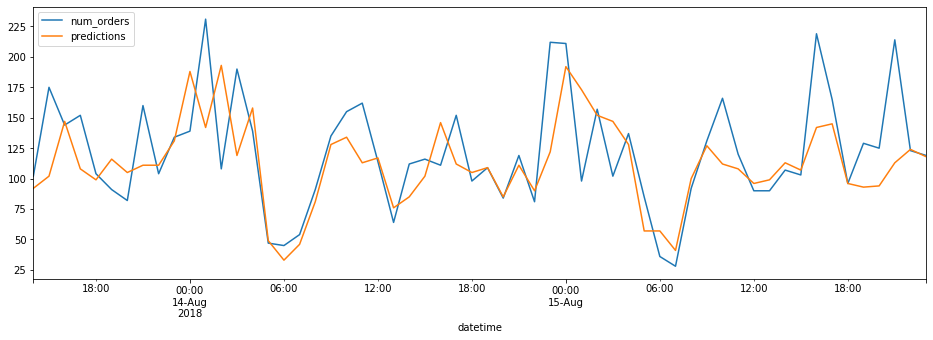

In [42]:
graph = target_test.copy()
predictions_taxi = pd.DataFrame(data = lgbm_test_prediction, columns = ['predictions'], index = features_test.index.copy())
df_merged = pd.merge(graph, predictions_taxi, how = 'left', left_index = True, right_index = True)
df_merged['predictions'] = df_merged['predictions'].astype('int64')
df_merged['2018-08-12':'2018-08-15'].plot(figsize=(16,5))

Модель вроде бы следит за основными движениями графика, однако, к сожалению, не улавливает пиков.

### <p style="text-align:center"> Вывод</p>

##### В ходе тестирования моделей были сделаны следующие выводы:

___


1. Модели линейной регрессии и случайного леса не прошли порог адекватности.


2. Модели LGBM и CatBoost оказались достаточно точными, однако только LGBM прошел порог по метрике качества.

___

Таким образом была выполнена работа по обучению моделей до заданной точности, и тестированию моделей, в целях предсказания количества заказов такси на следующий час.